# Brain Tumor Detection using Convolutional Neural Networks

## Setting up Enviroment

In [75]:
### For Data Manipulation
import zipfile as zf
import os
import shutil
from tqdm import tqdm
import cv2
import imutils 

### Basics
import numpy as np
import matplotlib.pyplot as plt

## Data processing

#### Uploading Data

In [76]:
files = zf.ZipFile("archive.zip", 'r')
files.extractall('data')
files.close()

#### Folders for Data

In [77]:

!mkdir TRAIN TEST VAL TRAIN\YES TRAIN\NO TEST\YES TEST\NO VAL\YES VAL\NO

A subdirectory or file TRAIN already exists.
Error occurred while processing: TRAIN.
A subdirectory or file TEST already exists.
Error occurred while processing: TEST.
A subdirectory or file VAL already exists.
Error occurred while processing: VAL.
A subdirectory or file TRAIN\YES already exists.
Error occurred while processing: TRAIN\YES.
A subdirectory or file TRAIN\NO already exists.
Error occurred while processing: TRAIN\NO.
A subdirectory or file TEST\YES already exists.
Error occurred while processing: TEST\YES.
A subdirectory or file TEST\NO already exists.
Error occurred while processing: TEST\NO.
A subdirectory or file VAL\YES already exists.
Error occurred while processing: VAL\YES.
A subdirectory or file VAL\NO already exists.
Error occurred while processing: VAL\NO.


#### Populating Folders

In [78]:
directory = os.getcwd()
print("Current working directory %s" % directory)

Current working directory C:\Users\npicc\CS445\final project


In [79]:
IMG_PATH = r"C:\Users\npicc\CS445\final project\data\brain_tumor_dataset\\"
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

### Cropping Data to be Standardized using Contours
I Will be using the contouring concept covered in this article: https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/

In [80]:
def crop_brain_contour(image):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    
    return new_image

#### Sorting Data

In [81]:
def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    i = 0
    labels = dict()
    ## Iterates through folders and adds images to respective folders
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = crop_brain_contour(img)
                    img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [82]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

#allocated directories and adds data
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 92.93it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 12.71it/s]

50 images loaded from VAL/ directory.


## Lets Visualize Our Data

In [83]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 16))
        
        cur = 1      
        for image in n_images:
            plt.subplot(rows_n, columns_n, cur)
            plt.imshow(image[0])
            
            plt.xticks([])
            plt.yticks([])
            cur += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"{label_to_str(label)}")
        plt.show()

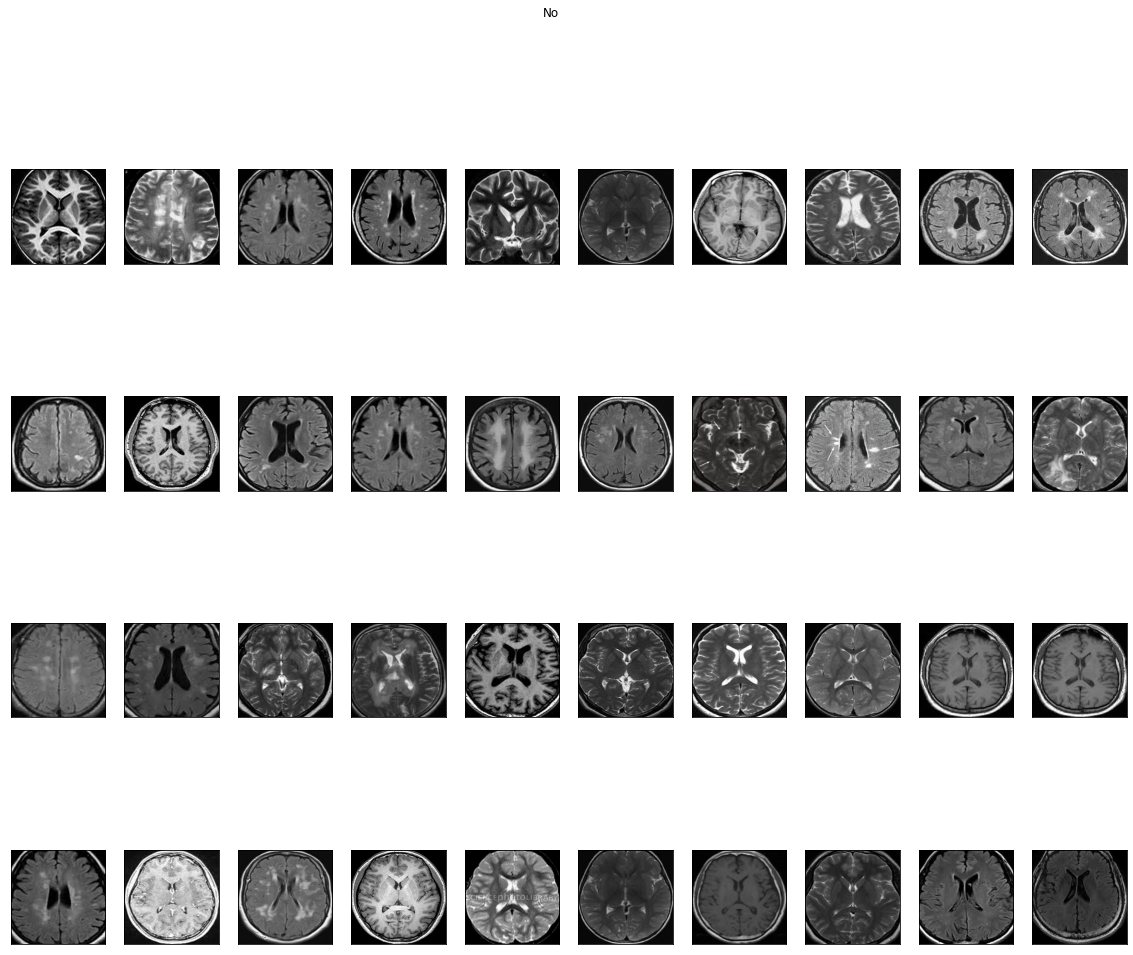

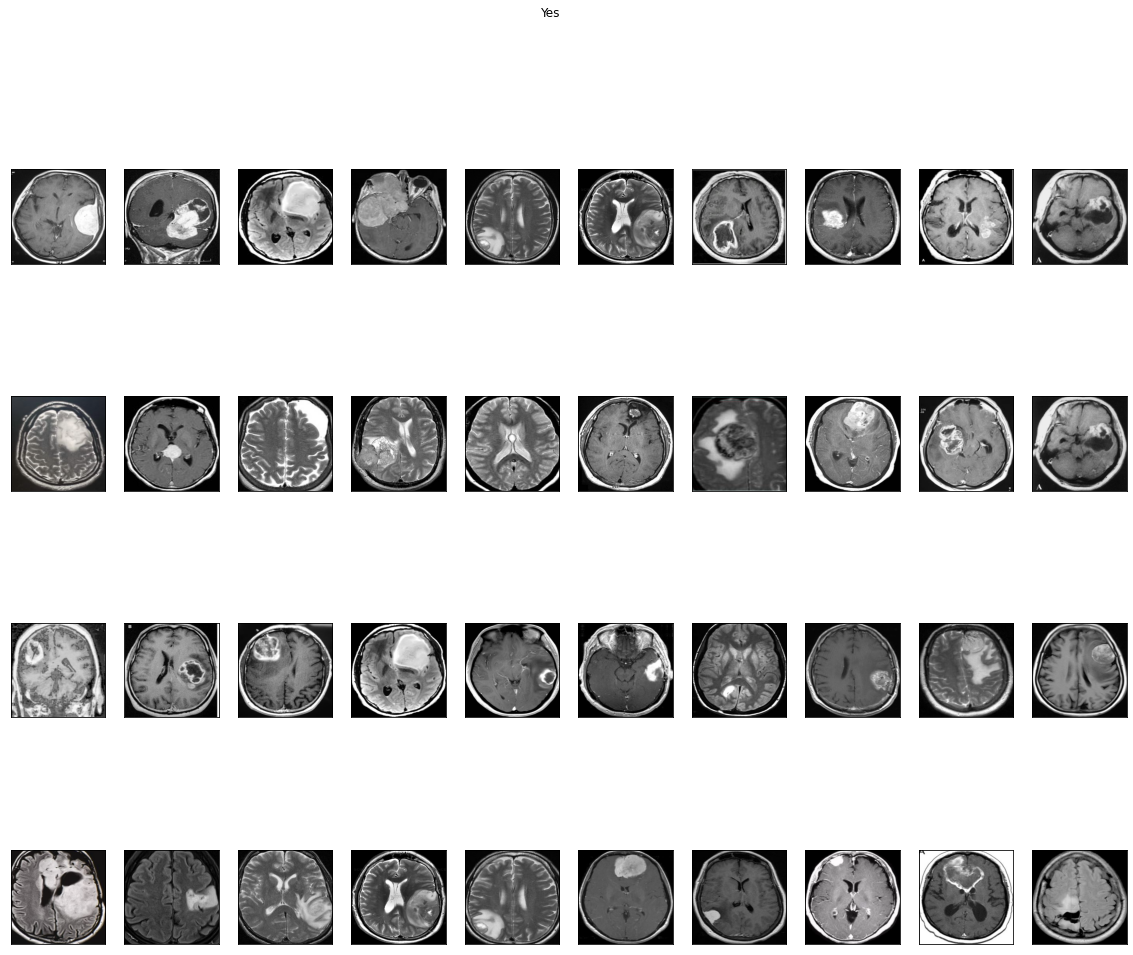

In [84]:
plot_sample_images(X_train, y_train)